In [3]:
import sys
sys.path.append('../')

import torch
from glob import glob
from tqdm import tqdm

from src.tacogfn.utils.molecules import sdf_to_single_smiles
from src.tacogfn.data.pharmacophore import PharmacoDB

import rdkit
rdkit.RDLogger.DisableLog('rdApp.*')

Load type files containing all information

In [4]:
files = glob('../dataset/types/it2_tt_v1.3_completeset_train*')

In [5]:
def process_line(line):
    info = line.split()
    pocket_id = info[3].split("/")[-1].split('_rec')[0] 
    ligand_id = info[4].split("/")[-1].split('rec_')[1].split('_lig')[0] 
    docking_score = float(info[-1][1:])
    return pocket_id, ligand_id, docking_score

Create a dataset with docking score (key is pocket_id + '_' + ligand_id)

In [6]:
dataset = {}

for file_path in files:
    with open(file_path, "r") as file:
        for line in tqdm(file):
            pocket_id, ligand_id, docking_score = process_line(line)
            key = pocket_id + '_' + ligand_id
            if key not in dataset:
                dataset[key] = [docking_score]        
            else:
                dataset[key].append(docking_score)

22566449it [00:29, 776342.85it/s]


In [7]:
# for file_path in files:
#     with open(file_path, "r") as file:
#         for line in file:
#             key = '3rlj_A_rec_1i38_dht'
#             if key in line:
#                 print(line)

We can only use a subset of this dataset

In [8]:
splits = torch.load('../dataset/split_by_name.pt')

In [9]:
get_pocket_id_and_ligand_id = lambda path: (path.split('/')[1].split('_rec')[0], path.split('/')[1].split('rec_')[1].split('_lig')[0])

In [10]:
train_pairs = [get_pocket_id_and_ligand_id(path) for path, _ in splits['train']]
train_keys = set(pair[0] + '_' + pair[1] for pair in train_pairs)

test_pairs = [get_pocket_id_and_ligand_id(path) for path, _ in splits['test']] 
test_keys = set(pair[0] + '_' + pair[1] for pair in test_pairs)

In [11]:
train_dataset = {key: dataset[key] for key in dataset.keys() if key in train_keys}
test_dataset = {key: dataset[key] for key in dataset.keys() if key in test_keys}

In [12]:
print('There are {} ligand pocket combinations in Train'.format(len(train_keys)))
print('There are {} ligand pocket combinations in Test'.format(len(test_keys)))

There are 84459 ligand pocket combinations in Train
There are 100 ligand pocket combinations in Test


In [13]:
len(train_dataset), len(test_dataset)
print('There are {} ligand pocket combinations in train'.format(len(train_dataset)))
print('There are {} ligand pocket combinations in test'.format(len(test_dataset)))

There are 76593 ligand pocket combinations in train
There are 89 ligand pocket combinations in test


We average the top docking scores for each protein ligand pair as label

In [14]:
acc_train_dataset = {
    key: min(scores + [0]) for key, scores in train_dataset.items()
}

acc_test_dataset = {
    key: min(scores + [0]) for key, scores in test_dataset.items()
}

Distribution of docking scores

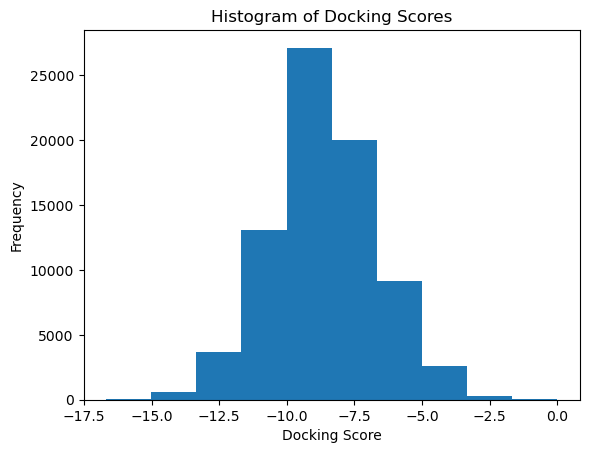

In [15]:
import matplotlib.pyplot as plt

docking_scores = acc_train_dataset.values()

plt.hist(docking_scores, bins=10)
plt.xlabel('Docking Score')
plt.ylabel('Frequency')
plt.title('Histogram of Docking Scores')
plt.show()

Get dataset in the form of (pdb_id, smiles, docking scores) 

In [16]:
import os

final_train_dataset = []
for key, score in tqdm(acc_train_dataset.items()):
    pdb_id = '_'.join(key.split('_')[:2])
    sdf_path = os.path.join('../dataset/crossdock', '_'.join(key.split('_')[2:]) + '_lig.sdf')
    smiles = sdf_to_single_smiles(sdf_path)
    
    final_train_dataset.append(
        (pdb_id, smiles, score)
    )

100%|██████████| 76593/76593 [00:15<00:00, 4985.33it/s]


In [17]:
all_smiles = list(set([data[1] for data in final_train_dataset]))
all_pdb_ids = list(set([data[0] for data in final_train_dataset]))
print('There are {} unique ligands'.format( len(all_smiles)))
print('There are {} unique pdb ids'.format( len(all_pdb_ids)))

There are 7776 unique ligands
There are 14016 unique pdb ids


Keep only ones we compute Pharmacophores for

In [18]:
db = PharmacoDB('../misc/pharmacophores.lmdb')
avail_keys = set(db.get_keys())

ultimate_train_dataset = []
for pdb_id, smiles, score in final_train_dataset:
    if pdb_id in avail_keys:
        ultimate_train_dataset.append((pdb_id, smiles, score))

In [19]:
len(ultimate_train_dataset)

72792

Split the dataset with MOOD considerations

In [20]:
gflownet_molecules = [data[1] for data in torch.load('../misc/examples_of_gflownet_produced_molecules.pt')]

In [21]:
# We should at least make sure the same ligand don't appear in both train and test
# let's split by ligand

In [22]:
import numpy as np
import datamol as dm
from rdkit import Chem

from sklearn.model_selection import ShuffleSplit

import splito

In [23]:
# Load the training dataset
dataset_feat = [dm.to_fp(Chem.MolFromSmiles(smi)) for smi in all_smiles if smi is not None]

# Load the deployment set
# Alternatively, you can also load an array of deployment-to-dataset distance
deployment_feat = [dm.to_fp(Chem.MolFromSmiles(smi)) for smi in gflownet_molecules]

In [24]:
# Define the candidate splitters
# Since we use the scikit-learn interface, this can also be sklearn Splitters
mols = [Chem.MolFromSmiles(smi) for smi in all_smiles if smi is not None]

splitters = {
    "Random": ShuffleSplit(),
    "Scaffold": splito.ScaffoldSplit(mols),
    "Perimeter": splito.PerimeterSplit(),
    "MaxDissimilarity": splito.MaxDissimilaritySplit(),
}

splitter = splito.MOODSplitter(splitters)

In [25]:
# get the rank of the splitting methods with the givent deployment set
splitter.fit(X=np.stack(dataset_feat), X_deployment=np.stack(deployment_feat))

2024-01-07 18:14:21.126 | INFO     | splito._mood_split:fit:308 - Ranked all different splitting methods:
              split  representativeness   best  rank
0            Random            0.500172  False   4.0
1          Scaffold            0.523466  False   3.0
2         Perimeter            0.666480   True   1.0
3  MaxDissimilarity            0.616836  False   2.0
2024-01-07 18:14:21.127 | INFO     | splito._mood_split:fit:309 - Selected Perimeter as the most representative splitting method


,split,representativeness,best,rank
0,Random,0.500172,False,4.0
1,Scaffold,0.523466,False,3.0
2,Perimeter,0.666480,True,1.0
3,MaxDissimilarity,0.616836,False,2.0


We are going to use Perimeter splitting because it produces best representativeness

In [ ]:
# Use a pretrained model
# Pharmacophore model
# merge later 